### Imports

In [1]:
# IMPORT PACKAGE
import os
import cv2
import math
import random
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output
from random import randint
from glob import glob
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence
import albumentations as A
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Add, Softmax, Dropout, LeakyReLU, UpSampling2D, concatenate, ZeroPadding2D, Activation, Input, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.regularizers import l2
from skmultilearn.model_selection import iterative_train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
#from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.layers import Input, Dense, Conv2D, GlobalAveragePooling2D, Lambda, Reshape, Dropout, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D, multiply, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.mixed_precision import Policy, set_global_policy
clear_output()

In [2]:
# GPU MEMORY GROWTH
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs.")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")
# ENCODE AND DECODE METHOD  

Memory growth set for GPUs.


In [3]:
mask_rgb_values = {
    'Forest': [0, 255, 0],
    'Agricultural Land': [165, 42, 42],
    'Road': [70, 130, 180],
    'Grassland': [50, 205, 50],
    'Water Bodies': [0, 0, 255],
    'Shrubland': [173, 255, 47],
    'Built-up': [255, 105, 45],
    'Unlabelled': [0, 0, 0],
}

def encode_categorical(mask, num_classes=8):
    cat_encoded = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype='float32')
    for i, value in enumerate(mask_rgb_values.values()):
        condition = np.all(mask == value, axis=-1)
        cat_encoded[condition, i] = 1.0
    return cat_encoded


def decode_prediction(pred, num_classes=8):
  argmax_idx = np.array([np.argmax(x) for x in pred.reshape((-1, num_classes))])
  argmax_idx = argmax_idx.reshape(pred.shape[:-1])

  decoded_mask=np.zeros(shape=(*pred.shape[:-1], 3), dtype='uint8')

  for i, value in enumerate(mask_rgb_values.values()):
    decoded_mask[argmax_idx==i] = value
  return decoded_mask  

In [4]:
  
# CUSTOM DATA GENERATOR  
  
class ImageDataGenerator(Sequence):
    def __init__(self,
                 img_paths,
                 mask_paths,
                 batch_size,
                 augment,
                 num_classes=8,
                 shuffle=False):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.augment = augment

        self.indexes = np.arange(len(self.img_paths))
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.img_paths) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Get batch indexes
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_img_paths = [self.img_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]

        # Load and preprocess batch
        X, y = self.__load_batch(batch_img_paths, batch_mask_paths)
        return X, y
    
    def __load_batch(self, batch_img_paths, batch_mask_paths):
        batch_img = []
        batch_mask = []

        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            # Load image and mask
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

            # Encode mask as categorical
            mask = encode_categorical(mask, num_classes=self.num_classes)
            
            # Perform augmentation if enabled
            if self.augment:
                augmented_images, augmented_masks = self.data_augmentation(image, mask)
                batch_img.extend(augmented_images)
                batch_mask.extend(augmented_masks)
            else:
                batch_img.append(image.astype(np.float32) / 255.0)
                batch_mask.append(mask.astype(np.float32))

        return np.array(batch_img, dtype='float32'), np.array(batch_mask, dtype='float32')   

    def data_augmentation(self, image, mask):
        transform = A.Compose([
            A.RandomBrightnessContrast(p=0.2),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ])

        augmented = transform(image=image, mask=mask)
        augmented_image = augmented['image']
        augmented_mask = augmented['mask']

        original_image = image.astype(np.float32) / 255.0
        original_mask = mask.astype(np.float32) 
        augmented_image = augmented_image.astype(np.float32) / 255.0
        augmented_mask = augmented_mask.astype(np.float32)

        return [original_image, augmented_image], [original_mask, augmented_mask]    

In [5]:

# Load CSVs
train_df = pd.read_csv('/home/rdadmin/Tsiyon/notebook/SPLITS/train.csv')
val_df = pd.read_csv('/home/rdadmin/Tsiyon/notebook/SPLITS/val.csv')
test_df = pd.read_csv('/home/rdadmin/Tsiyon/notebook/SPLITS/test.csv')

# Extract paths from the CSVs
train_img_paths = train_df['image_path'].tolist()
train_mask_paths = train_df['mask_path'].tolist()

val_img_paths = val_df['image_path'].tolist()
val_mask_paths = val_df['mask_path'].tolist()

test_img_paths = test_df['image_path'].tolist()
test_mask_paths = test_df['mask_path'].tolist()

In [6]:
# METRICS
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def combined_dice_crossentropy_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    crossentropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return dice + crossentropy


class MeanIoUWrapper(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='iou_metric', **kwargs):
        super(MeanIoUWrapper, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.iou_metric = MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        self.iou_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.iou_metric.result()

    def reset_states(self):
        self.iou_metric.reset_states()

def iou_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(tf.argmax(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)  
    
def dice_coef_metric(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)
input_shape = (256, 256, 3)
n_classes = 8

In [7]:



# MODEL DEFINITION
from tensorflow.keras.applications import Xception 
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding='same', use_bias=False):
    x = Conv2D(
        num_filters, 
        kernel_size=kernel_size, 
        dilation_rate=dilation_rate, 
        padding=padding, 
        use_bias=use_bias, 
        #kernel_initializer='he_normal',
        #kernel_regularizer=l2(0.1)  # Added L2 regularization
    )(block_input)
    x = BatchNormalization()(x)  # Added Batch Normalization
    x = Dropout(0.3)(x)
    return Activation('relu')(x)

def DilatedSpatialPyramidPooling(input):
    dims = input.shape
    x = Conv2D(256, (1, 1), padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    atrous_block1 = Conv2D(256, (3, 3), padding='same', dilation_rate=(1, 1), use_bias=False)(input)
    atrous_block1 = BatchNormalization()(atrous_block1)
    atrous_block1 = ReLU()(atrous_block1)

    atrous_block6 = Conv2D(256, (3, 3), padding='same', dilation_rate=(6, 6), use_bias=False)(input)
    atrous_block6 = BatchNormalization()(atrous_block6)
    atrous_block6 = ReLU()(atrous_block6)

    atrous_block12 = Conv2D(256, (3, 3), padding='same', dilation_rate=(12, 12), use_bias=False)(input)
    atrous_block12 = BatchNormalization()(atrous_block12)
    atrous_block12 = ReLU()(atrous_block12)

    atrous_block18 = Conv2D(256, (3, 3), padding='same', dilation_rate=(18, 18), use_bias=False)(input)
    atrous_block18 = BatchNormalization()(atrous_block18)
    atrous_block18 = ReLU()(atrous_block18)

    pooling = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(input)
    pooling = Conv2D(256, (1, 1), padding='same', use_bias=False)(pooling)
    pooling = BatchNormalization()(pooling)
    pooling = ReLU()(pooling)
    pooling = UpSampling2D(size=(dims[-3] // pooling.shape[1], dims[-2] // pooling.shape[2]), interpolation='bilinear')(pooling)

    concat = concatenate([x, atrous_block1, atrous_block6, atrous_block12, atrous_block18, pooling])
    output = Conv2D(256, (1, 1), padding='same', use_bias=False)(concat)
    output = BatchNormalization()(output)
    output = ReLU()(output)

    return output
def DeeplabV3Plus(image_size, num_classes):
    input = Input(shape=(image_size, image_size, 3))
    xception = Xception(weights='imagenet', include_top=False, input_tensor=input)

    x = xception.get_layer('block13_sepconv2_bn').output  # Changed to an appropriate layer in Xception
    x = DilatedSpatialPyramidPooling(x)

    input_a = UpSampling2D(size=(image_size // x.shape[1], image_size // x.shape[2]), interpolation='bilinear')(x)
    input_b = xception.get_layer('block4_sepconv2_bn').output  # Changed to an appropriate layer in Xception
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    # Upsample 'input_b' to match 'input_a' size
    input_b = UpSampling2D(size=(input_a.shape[1] // input_b.shape[1], input_a.shape[2] // input_b.shape[2]), interpolation='bilinear')(input_b)
    x = concatenate([input_a, input_b], axis=-1)

    x = convolution_block(x)
    x = convolution_block(x)
    x = UpSampling2D(size=(image_size // x.shape[1], image_size // x.shape[2]), interpolation='bilinear')(x)
    output = Conv2D(num_classes, kernel_size=(1, 1), padding='same', activation='softmax')(x)
    return Model(inputs=input, outputs=output, name='DeepLabV3')


In [8]:

#MODEL TRAINING
train_generator = ImageDataGenerator(
    img_paths=train_img_paths,
    mask_paths=train_mask_paths,
    batch_size=8,
    augment=True,  # Augmentation is enabled for training
    num_classes=8,
    shuffle=True  # Shuffling enabled for training
)

val_generator = ImageDataGenerator(
    img_paths=val_img_paths,
    mask_paths=val_mask_paths,
    batch_size=8,
    augment=False,  # No augmentation for validation
    num_classes=8,
    shuffle=False  # No shuffling for validation (ensure deterministic behavior)
)

test_generator = ImageDataGenerator(
    img_paths=test_img_paths,
    mask_paths=test_mask_paths,
    batch_size=8,
    augment=False,  # No augmentation for testing
    num_classes=8,
    shuffle=False  # No shuffling for testing (ensure deterministic behavior)
)

for image, mask in train_generator:
    print(image.shape)
    print(mask.shape)
    break 
    
img, label = test_generator.__getitem__(4)
img.shape, label.shape

(16, 256, 256, 3)
(16, 256, 256, 8)


((8, 256, 256, 3), (8, 256, 256, 8))

In [ ]:
from tensorflow.keras.models import Model
# Set mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)
saved_model_path = "/home/rdadmin/Tsiyon/NEWONE/MODELSAVED/1AEDEEPXCEP_best.weights.h5"
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = DeeplabV3Plus(image_size=256, num_classes=8)
    adamw_optimizer = Adam(learning_rate=1e-4, weight_decay=1e-5)
    model.load_weights(saved_model_path)
    model.compile(optimizer=adamw_optimizer, 
              loss=combined_dice_crossentropy_loss, 
              metrics=[dice_coef_metric, jacard_coef, MeanIoUWrapper(num_classes=n_classes)])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


I0000 00:00:1739512861.686848 2448256 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7392 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:06:00.0, compute capability: 7.5
I0000 00:00:1739512861.689675 2448256 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7392 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:07:00.0, compute capability: 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

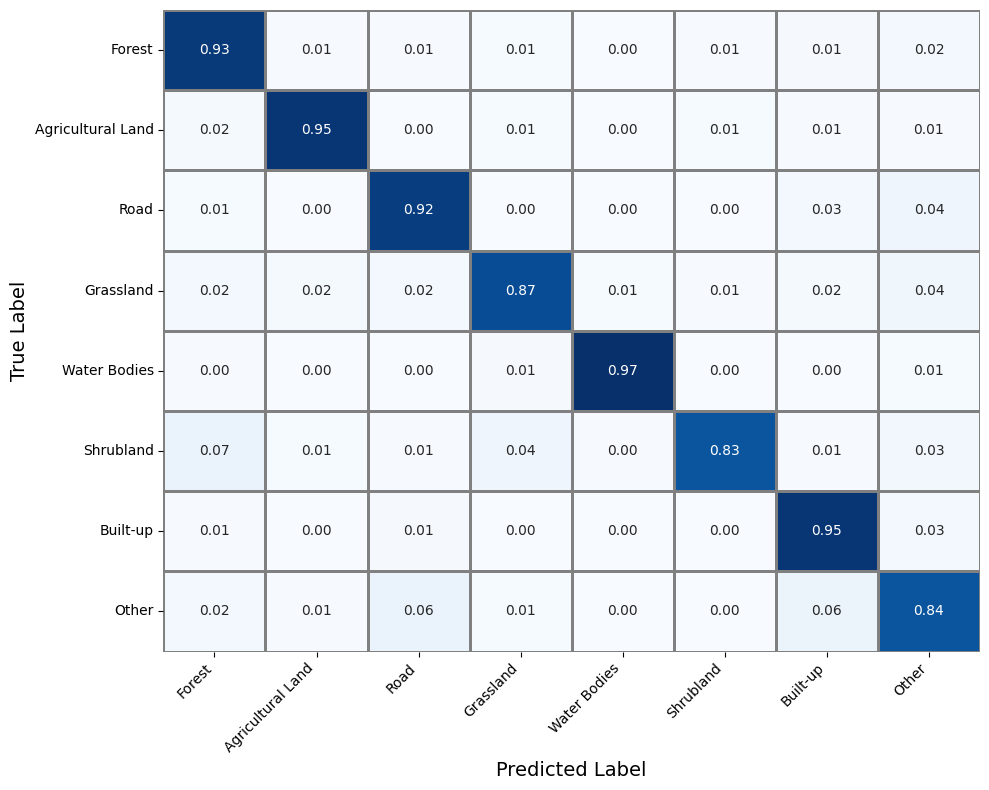

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

total_steps = len(val_generator)  
# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = val_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)

# Convert the lists to numpy arrays and flatten them
y_true_flat = np.concatenate(all_true, axis=None)  # Concatenate and flatten true labels
y_pred_flat = np.concatenate(all_preds, axis=None)  # Concatenate and flatten predictions

# Class labels for the confusion matrix
class_labels = ['Forest', 'Agricultural Land', 'Road', 'Grassland',
                'Water Bodies', 'Shrubland', 'Built-up', 'Other']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Handle NaN values

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',
                 xticklabels=class_labels, yticklabels=class_labels, fmt='.2f', cbar=False,  # Set cbar=False to remove the color bar
                 linewidths=0.722819, linecolor='gray')

# Increase font size of text labels
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Make all four borders bold and equal
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust thickness (e.g., 2 for bold)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add title
plt.title('')

# Save the plot as a file with high quality (300 dpi)
plt.tight_layout()
plt.savefig('/home/rdadmin/Tsiyon/NEWONE/RESULT/DEEPXCP_CM.png', dpi=300)

# Show the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-02-14 10:36:30.118493: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

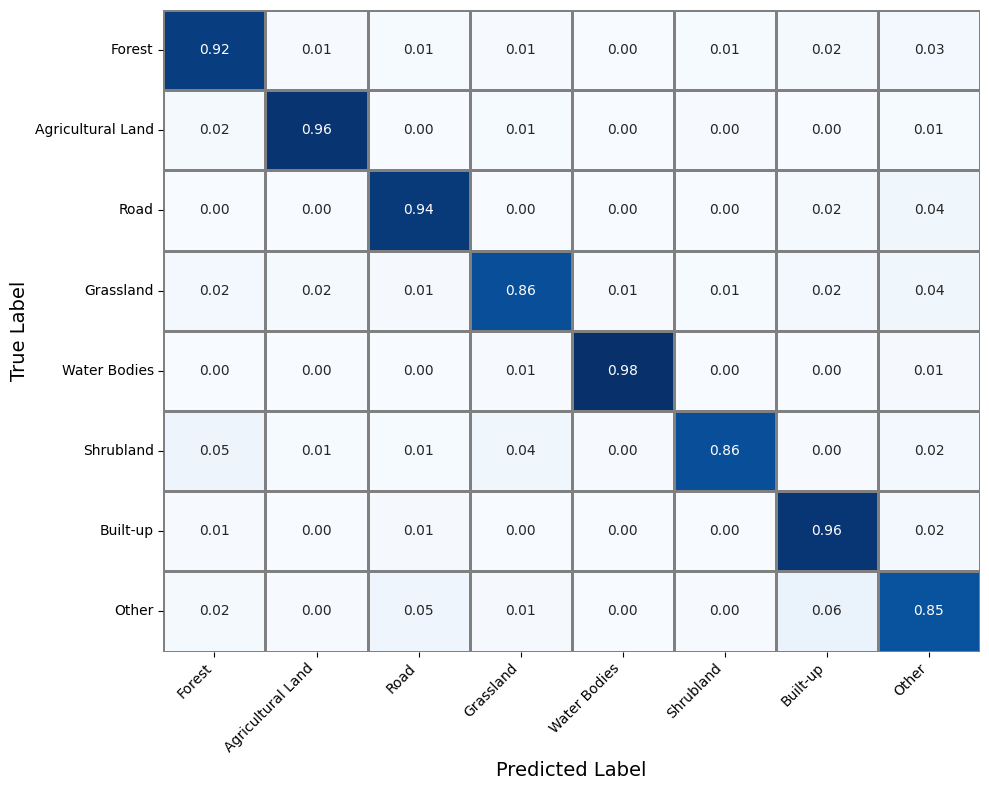

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

total_steps = len(test_generator)  
# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)

# Convert the lists to numpy arrays and flatten them
y_true_flat = np.concatenate(all_true, axis=None)  # Concatenate and flatten true labels
y_pred_flat = np.concatenate(all_preds, axis=None)  # Concatenate and flatten predictions

# Class labels for the confusion matrix
class_labels = ['Forest', 'Agricultural Land', 'Road', 'Grassland',
                'Water Bodies', 'Shrubland', 'Built-up', 'Other']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Handle NaN values

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',
                 xticklabels=class_labels, yticklabels=class_labels, fmt='.2f', cbar=False,  # Set cbar=False to remove the color bar
                 linewidths=0.722819, linecolor='gray')

# Increase font size of text labels
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Make all four borders bold and equal
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Adjust thickness (e.g., 2 for bold)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add title
plt.title('')

# Save the plot as a file with high quality (300 dpi)
plt.tight_layout()
plt.savefig('/home/rdadmin/Tsiyon/NEWONE/RESULT/DEEPXCP_CM.png', dpi=300)

# Show the plot
plt.show()

In [10]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(val_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = val_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

2025-02-14 09:03:07.508027: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-02-14 09:03:07.508223: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-02-14 09:03:07.515817: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-02-14 09:03:14.634603: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1739512995.143286 2451975 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1739512995.200945 2451976 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


2025-02-14 09:03:22.508456: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


2025-02-14 09:03:24.611279: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


2025-02-14 09:03:29.198389: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


2025-02-14 09:03:38.127630: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


2025-02-14 09:03:57.478637: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-02-14 09:04:34.922436: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-02-14 09:05:45.526740: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [11]:
from sklearn.metrics import classification_report

# Define class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7']  

# Generate classification report
print("Classification Report (Validation):")
print(classification_report(y_true_flat, y_pred_flat, labels=np.arange(len(class_labels)), target_names=class_labels))

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.91      0.93      0.92  13413412
           1       0.96      0.95      0.95   7155253
           2       0.91      0.92      0.92  20756227
           3       0.88      0.87      0.87   6034377
           4       0.97      0.97      0.97   5579549
           5       0.92      0.83      0.87   3565060
           6       0.93      0.95      0.94  27559070
           7       0.87      0.84      0.85  18435356

    accuracy                           0.91 102498304
   macro avg       0.92      0.91      0.91 102498304
weighted avg       0.91      0.91      0.91 102498304



In [12]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(test_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-02-14 09:53:26.381347: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-02-14 09:58:13.655684: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(test_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

2024-12-30 08:52:33.223557: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-12-30 08:52:33.223757: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-12-30 08:52:33.230752: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-12-30 08:52:41.637907: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1735537962.215512 1285151 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1735537962.266155 1285150 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


2024-12-30 08:52:50.418112: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


2024-12-30 08:52:52.741272: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


2024-12-30 08:52:57.469692: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


2024-12-30 08:53:06.471663: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


2024-12-30 08:53:24.289033: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-12-30 08:54:00.848067: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-12-30 08:55:13.693035: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-12-24 15:03:00.973650: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

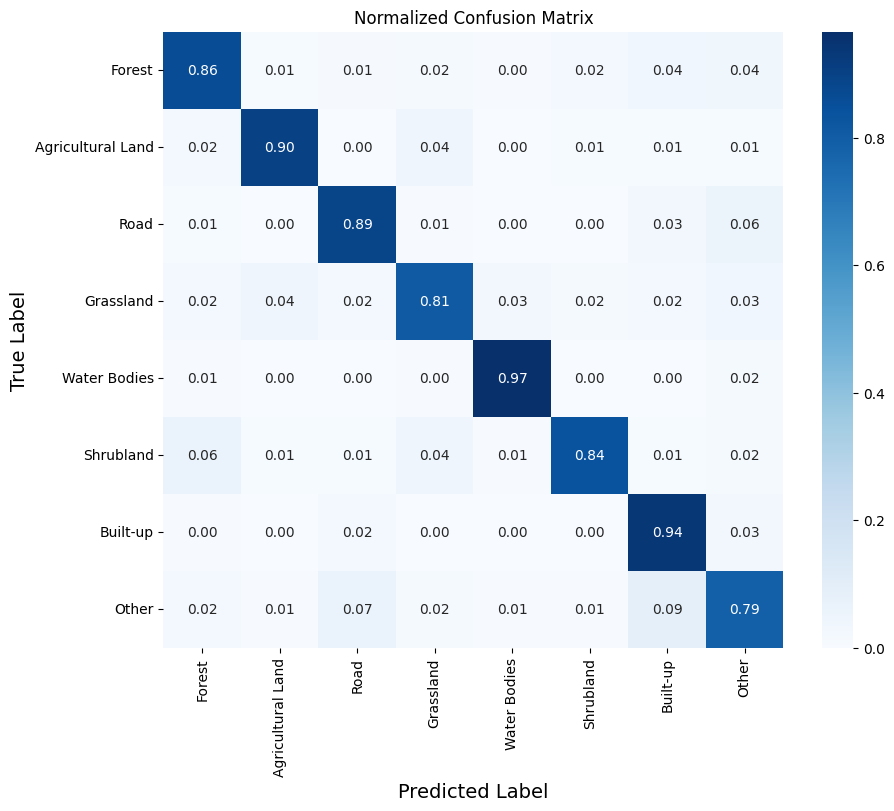

Classification Report:
                   precision    recall  f1-score   support

           Forest       0.90      0.86      0.88  15076054
Agricultural Land       0.91      0.90      0.91   7525107
             Road       0.89      0.89      0.89  23076648
        Grassland       0.79      0.81      0.80   6830640
     Water Bodies       0.93      0.97      0.95   6098504
        Shrubland       0.85      0.84      0.84   4529601
         Built-up       0.90      0.94      0.92  32077164
            Other       0.83      0.79      0.81  21112682

         accuracy                           0.88 116326400
        macro avg       0.87      0.87      0.87 116326400
     weighted avg       0.88      0.88      0.88 116326400

Confusion Matrix:
[[12981704   146750   183959   263221    58309   324305   527722   590084]
 [  164837  6808898     5712   335877    12621    64992    65144    67026]
 [  201263    16295 20599494   124806     7972    10449   732579  1383790]
 [  149536   290076   1

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Confusion Matrix and Classification Report
class_labels = ['Forest', 'Agricultural Land', 'Road', 'Grassland',
                'Water Bodies', 'Shrubland', 'Built-up', 'Other']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Handle NaN values

# Display Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, fmt='.2f', cbar=True)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=class_labels))

# Confusion Matrix (Raw Numbers)
print("Confusion Matrix:")
print(conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2024-12-30 09:15:50.825450: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

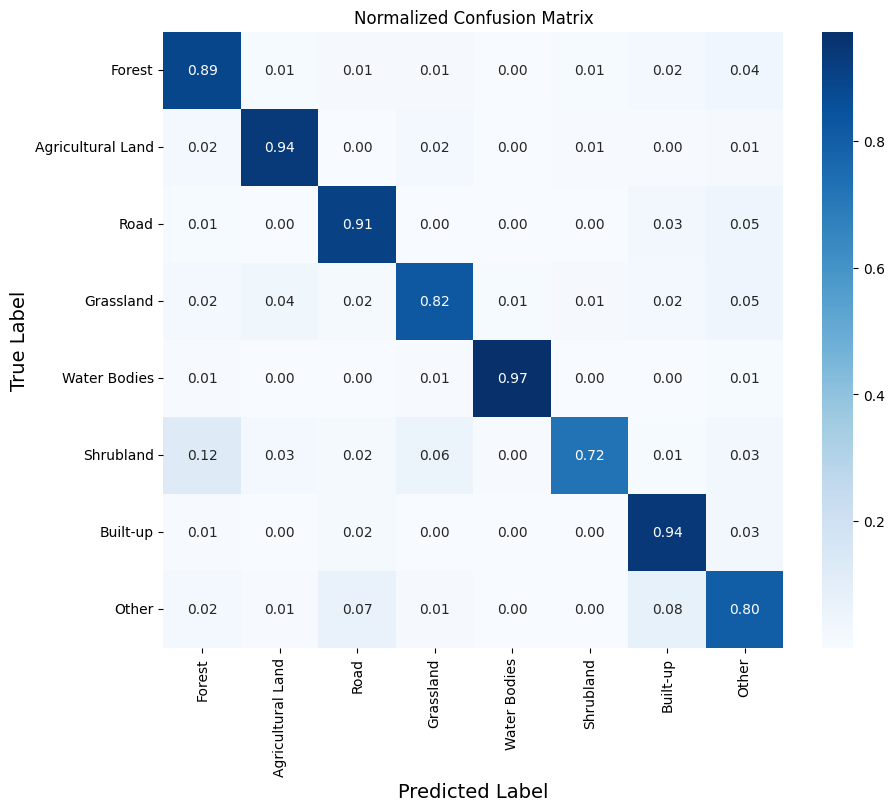

Classification Report:
                   precision    recall  f1-score   support

           Forest       0.88      0.89      0.89  15193974
Agricultural Land       0.91      0.94      0.92   7628487
             Road       0.90      0.91      0.90  23465305
        Grassland       0.85      0.82      0.83   7230759
     Water Bodies       0.96      0.97      0.97   6309100
        Shrubland       0.89      0.72      0.80   4489819
         Built-up       0.91      0.94      0.93  32128108
            Other       0.83      0.80      0.82  20667280

         accuracy                           0.89 117112832
        macro avg       0.89      0.87      0.88 117112832
     weighted avg       0.89      0.89      0.89 117112832

Confusion Matrix:
[[13566598   167623   190501   206847    41018   118236   324828   578323]
 [  153002  7135500     9336   152924      574    50689    35554    90908]
 [  224800    12772 21320223    80715     7462     3095   676240  1139998]
 [  165434   286704   1

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    batch = test_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Confusion Matrix and Classification Report
class_labels = ['Forest', 'Agricultural Land', 'Road', 'Grassland',
                'Water Bodies', 'Shrubland', 'Built-up', 'Other']

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)  # Handle NaN values

# Display Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, fmt='.2f', cbar=True)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=class_labels))

# Confusion Matrix (Raw Numbers)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(val_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = val_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

In [12]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score
total_steps = len(val_generator)

def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        if union == 0:  # Skip classes with no ground truth
            continue
        iou.append(intersection / union)
    return iou, np.nanmean(iou) if iou else (iou, np.nan)

def calculate_dice(y_true, y_pred, num_classes):
    dice = []
    for cls in range(num_classes):
        true_cls = (y_true == cls)
        pred_cls = (y_pred == cls)
        intersection = np.logical_and(true_cls, pred_cls).sum()
        if true_cls.sum() + pred_cls.sum() == 0:  # Skip classes with no ground truth
            continue
        dice.append(2 * intersection / (true_cls.sum() + pred_cls.sum()))
    return dice, np.nanmean(dice) if dice else (dice, np.nan)

def calculate_pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Initialize arrays to store predictions and true labels
all_preds = []
all_true = []

# Ensure the test generator is resettable

# Loop through the test generator to collect predictions and ground truths
for i in range(total_steps):
    # Get the next batch of images and masks from the generator
    batch = val_generator[i]
    imgs, masks = batch[0], batch[1]  # Assuming the generator returns (images, masks)

    preds = model.predict(imgs)  # Predict on the batch
    preds = preds.argmax(axis=-1)  # Convert probabilities to class indices
    masks = masks.argmax(axis=-1)  # Convert one-hot masks to class indices

    all_preds.append(preds)
    all_true.append(masks)


# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Calculate IoU and mIoU
num_classes = 8
iou, miou = calculate_iou(all_true, all_preds, num_classes)
print(f"IoU per class: {iou}")
print(f"mIoU: {miou}")

# Calculate Dice Coefficient
dice, mean_dice = calculate_dice(all_true, all_preds, num_classes)
print(f"Dice Coefficient per class: {dice}")
print(f"Mean Dice Coefficient: {mean_dice}")

# Calculate Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(all_true, all_preds)
print(f"Pixel Accuracy: {pixel_accuracy}")

# Flatten arrays for sklearn metrics
y_true_flat = all_true.flatten()
y_pred_flat = all_preds.flatten()

# Calculate F1, Recall, and Precision (weighted)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

2025-01-09 12:17:56.474159: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-09 12:17:56.474342: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-01-09 12:17:56.483225: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2025-01-09 12:18:08.085352: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1736414288.593482  267242 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1736414288.646790  267246 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


2025-01-09 12:18:16.621369: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


2025-01-09 12:18:19.174588: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


2025-01-09 12:18:24.603589: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


2025-01-09 12:18:35.033789: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


2025-01-09 12:18:56.108688: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-01-09 12:19:39.121334: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-01-09 12:21:04.090933: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 